# **Colab + PyTorch + Google Drive進行自定義模型影像分類推論**
歐尼克斯實境互動工 作室 OmniXRI Jack 2020.12.08整理製作

本範例從雲端下載資料集到虛擬機，再連接雲端硬碟Google Drive載入訓練好的模型並進行推論，主要使用PyTorch進行程式開發。

執行本範例前，請先確認系統已處於GPU開啟模式，選單【編輯】─【筆記本設定】─【硬體加速器】─ GPU。

主要工作如下

*   掛載雲端硬碟到虛擬機
*   複製資料集到虛擬機
*   取得資料集路徑
*   製作PyTorch格式資料集
*   建立卷積神經網路
*   進行推論











In [1]:
!nvidia-smi # 檢查GPU硬體環境及CUDA版本

Thu Dec 17 16:11:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import tensorflow as tf
import cv2
import sys

print(sys.version) # 檢查Python版本
print(torch.__version__) # 檢查PyTorch版本
print(tf.__version__) # 檢查TensorFlow版本
print(cv2.__version__) # 檢查OpenCV版本

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
1.7.0+cu101
2.3.0
4.1.2


# **掛載雲端硬碟到虛擬機**

In [3]:
# 導入Google Drvie套件包
from google.colab import drive

# 將自己的雲端硬碟掛載到Colab虛擬機上
# 參考資料來源:https://colab.research.google.com/drive/1i41Whco5KIb7EuntKYwTVORAkAwCmlkF
drive.mount('/content/gdrive')

# 點選 Go to this URL in a browser: 後的網址，並複製授權碼(Authorization Code)
# 貼到到下方 Authorization Code 空格位置
# 雲端硬碟成功掛載到Colab虛擬機下 /content/gdriver/MyDrive 
# 點選畫面左方檔案夾圖示亦能看到掛載結果

# 本範例使用的資料集及最後完成訓練的模型及參數會存放在雲端硬碟指定路徑下

# 列出掛載之硬碟目錄
!ls /content/gdrive/MyDrive/test
# 顯示目前虛擬機工作路徑
!pwd

Mounted at /content/gdrive
cats_and_dogs_filtered.zip  OmniXRI_Logo.jpg	  PyTorch_Test1.ipynb
dict.pt			    OmniXRI_Logo.mp4
OmniXRI_Logo_avc.mp4	    OmniXRI_Logo_out.mp4
/content


# **複製資料集到虛擬機**

在Colab虛擬機上硬碟創建/dataset路徑，將資料集(cats_and_dogs_filtered.zip)從網路上下載到/dataset並解壓縮。該資料集只訓練用的貓狗圖片各1000張，檔名為cat.n.jpg 及 dog.n.jpg，n為0999，驗證用的貓狗圖片各500張，檔名為cat.n.jpg 及 dog.n.jpg，n為2000到2499。 

In [4]:
# 建立/dataset路徑
!mkdir /content/dataset 
# 下載資料集到虛擬機硬碟
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/dataset/cats_and_dogs_filtered.zip 
# 解壓縮資料集
!unzip /content/dataset/cats_and_dogs_filtered.zip -d /content/dataset 
# 列出資料集路徑清單
!ls /content/dataset 

--2020-12-17 16:12:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/dataset/cats_and_dogs_filtered.zip’

/content/dataset/ca 100%[===================>]  65.43M  66.5MB/s    in 1.0s    

2020-12-17 16:12:09 (66.5 MB/s) - ‘/content/dataset/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  /content/dataset/cats_and_dogs_filtered.zip
   creating: /content/dataset/cats_and_dogs_filtered/
  inflating: /content/dataset/cats_and_dogs_filtered/vectorize.py  
   creating: /content/dataset/cats_and_dogs_filtered/validation/
   creating: /content/dataset/cats_and_dogs_filtered/train/
   creating: /content/dataset/cats_and_dogs_filtered/v

# **建立卷積神經網路**

In [5]:
import torch # 導入PyTorch函式庫
import torch.nn as nn # 導入PyTorch函式庫
import torch.nn.functional as F #導入神經網路相關函式庫

class CNN(nn.Module): # 建立CNN類別函式
    def __init__(self, batch ): # 函數初始化
        super(CNN, self).__init__()
        # 定義第一卷積及最大池化層
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2)
        # 定義第二卷積及最大池化層
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2)
        # 定義第三卷積及最大池化層
        self.conv_3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2)
        #定義第一全連接層
        self.fc_1 = nn.Linear(128*(28*28) , 512)
        #定義第二全連接層
        self.fc_2 = nn.Linear(512, 2) # 重要，輸出2個類別
        
    def forward(self, x): # 正向推論函式
        
        out = self.maxpool_1(F.relu(self.conv_1(x))) # 執行第一卷積及池化層
        out = self.maxpool_2(F.relu(self.conv_2(out))) # 執行第二卷積及池化層
        out = self.maxpool_3(F.relu(self.conv_3(out))) # 執行第三卷積及池化層
        out = out.view(-1, self.num_flat_features(out)) # 執行平坦化
        out = F.relu(self.fc_1(out)) # 執行第一全連接層
        out = F.softmax(self.fc_2(out)) # 執行第二全連接層
        return out # 得到最後輸出並返回
    
    def num_flat_features(self, x): # 計算平坦化特徵數量
        size = x.size()[1:] # 求得資料集大小
        num_features = 1

        for s in size:
            num_features *= s # 求特徵數量

        return num_features # 返回特徵值數量

# **進行推論**

Start load model...
Load done.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.1950, 0.8050],
        [0.0022, 0.9978],
        [0.1323, 0.8677],
        [0.0678, 0.9322],
        [0.3437, 0.6563],
        [0.9241, 0.0759],
        [0.0740, 0.9260],
        [0.1485, 0.8515],
        [0.0116, 0.9884],
        [0.9481, 0.0519],
        [0.0022, 0.9978],
        [0.0101, 0.9899],
        [0.3282, 0.6718],
        [0.0831, 0.9169],
        [0.3693, 0.6307],
        [0.7873, 0.2127]], device='cuda:0')
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')


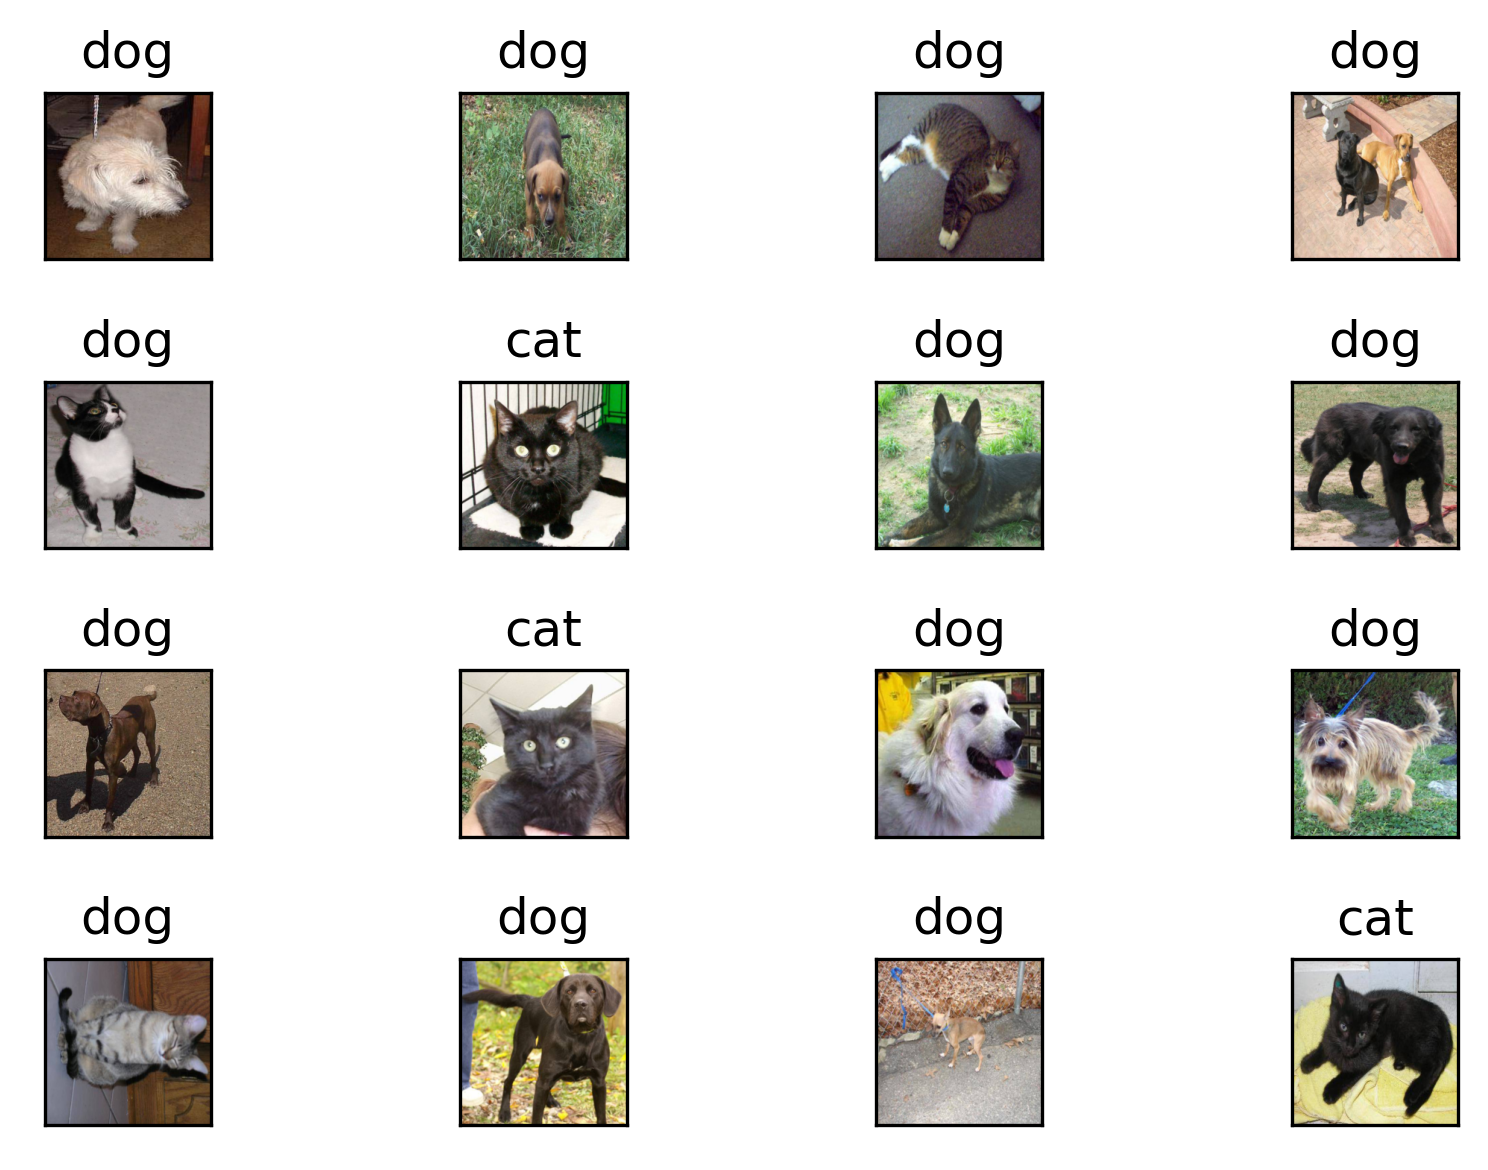

In [6]:
import os
import torch # 導入PyTorch函式庫
import torch.nn as nn # 導入PyTorch函式庫
import torch.optim as optim # 導入PyTorch優化器函式庫
from torchvision import datasets, transforms, models # 導入torchvision資料集、轉換及模型函式
import numpy as np
import matplotlib.pyplot as plt # 導入matplotlib繪函式庫

# 取得測試資料集路徑
base_dir = '/content/dataset/cats_and_dogs_filtered'
test_dir = os.path.join(base_dir, 'validation')

# 定義影像轉換函式，把正規化數值轉回影像
def cvt_img(im): 
    im = im.cpu().numpy().transpose((1, 2, 0)) # 資料轉置
    mean = np.array([0.5, ]) # 平均值
    std = np.array([0.5, ]) # 標準差
    im = std * im + mean # 將數值轉回影像

    return im # 返回影像

# 將資料轉換強制調整大小至224x224並將影像數值正規化
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# 取得測試資料集並轉換
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
# 隨機取出batch_size張影像
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
# 設定繪製解析度
fig = plt.figure(dpi=300)

# 設定裝置，預設以GPU（CUDA）執行，若無則採CPU計算
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16 # 指定批量大小
model = CNN(batch_size) # 建立模型

print('Start load model...')
# 載入雲端硬碟中的模型及參數檔到GPU "cuda"
model.load_state_dict(torch.load('/content/gdrive/MyDrive/test/dict.pt', map_location="cuda:0"))
model.to(device)
print('Load done.')

model.eval() # 將模型設置在評估模式以便進行推論

for idx, (data,_) in enumerate(test_loader): # 推論迴圈
    
    with torch.no_grad(): # 無梯度
    
        if idx>=1: break # 若標籤大於等於1則結束

        predict = model(data.to(device)) # 資料載入裝置並產生預測結果
        
        _, predicted = torch.max(predict, 1) # 找出輸出值最大的項目
        
        print(predict) # 列出預測結果數值
        print(predicted) # 列出預測結果項目 
        
        for i in range(16): # 繪製16張影像推論結果
            plt.subplot(4,4,i+1) # 設定子圖繪製位置
            plt.xticks([]), plt.yticks([]) # XY軸不繪刻度
            plt.title('cat' if predicted[i].cpu().numpy()==0 else 'dog') # 若預測結果為零則表示為貓否則為狗
            plt.imshow(cvt_img(data[i])) # 繪製已轉換回影像的資料

plt.tight_layout() # 緊密排版繪製
plt.show() # 顯示結果